In [2]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

using CairoMakie
CairoMakie.activate!(type="png")
set_theme!(resolution=(400, 400))
CairoMakie.inline!(true)
using GraphMakie: graphplot
using CairoMakie.Colors
using GeometryBasics: Point

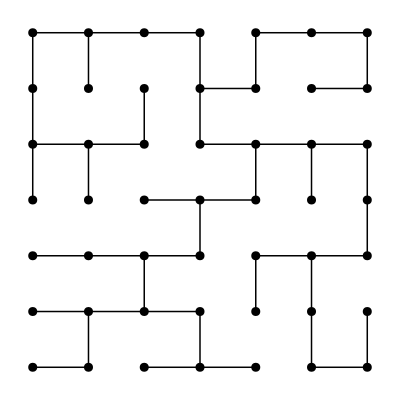

In [56]:
spanning_graph = "MTSF"

##  default parameters
# number of nodes on the side
n_side = 7

# interval [a,b]^2
a = 0
b = 1

# for sampling
absorbing_node = false
ust = false # for spanning trees

# proba to have an outlier edge
η = 0.
# uniform noise on edges
noise = 0.
# regularization parameter
q = 0.

if spanning_graph == "ST"
    absorbing_node = true
    ust = true
    η = 0.
    noise = 0.
elseif spanning_graph == "SF"
    q = 0.1
elseif spanning_graph == "CRSF"
    η = 0.2
    noise =0.1
elseif spanning_graph == "MTSF"
    q = 0.05
    η = 0.2
    noise = 0.
end

# edges weights?
weighted = false

# random generator
rng = Random.default_rng()

# number of nodes
n_v = n_side^2

# grid spacing
grid_spacing = (b-a)/(n_side - 1) 
# grid coordinates
x = flat_square_2d_grid(n_v, a, b)
# for plotting
function mylayout(g::AbstractGraph)
    # create iterator going over x-coord and y-coord 
    return Point.(zip(x[:, 1], x[:, 2]))
end

# planted ranking score
planted_score = randperm(rng,n_v);

meta_g = MetaGraph(n_v)

for u in 1:n_v
    for v in 1:n_v
        if u < v
            edge_exits = (norm(x[u,:]-x[v,:],1) < grid_spacing + 1e-10)
            if edge_exits
                h_u = planted_score[u]
                h_v = planted_score[v]
                θ = (h_u - h_v) * π / (n_v - 1)
                if (rand(rng) < η)
                    θ = rand(rng, (-n_v + 1):(n_v - 1)) * π / (n_v - 1)
                else
                    θ *= 1.0 + noise * 2 * (rand(rng) - 0.5)
                end
                add_edge!(meta_g, u, v, :angle, θ)
            end
        end
    end
end

crsf = multi_type_spanning_forest(rng, meta_g, q; weighted, absorbing_node, ust)


cycles = get_prop(crsf, :cycle_nodes)
cycle_g = MetaGraph(n_v)

for c in cycles 
    for u in 1:n_v
        for v in 1:n_v
            if u < v
                edge_exits = (norm(x[u,:]-x[v,:],1) < grid_spacing + 1e-10)
                u_in_c = (indexin(u, c)[1] !== nothing)
                v_in_c = (indexin(v, c)[1] !== nothing)

                if u_in_c && v_in_c && edge_exits
                    add_edge!(cycle_g, u, v)
                end
            end
        end
    end
end


f, ax, p = graphplot(crsf; layout=mylayout)
hidedecorations!(ax); hidespines!(ax)
ax.aspect = DataAspect()
f

In [8]:
roots = get_prop(crsf, :roots)

Int64[]

In [22]:
cycles = get_prop(crsf, :cycle_nodes)

1-element Vector{Vector{Int64}}:
 [13, 14, 21, 20]